# 2. Preprocessing
## 2.05 Preparing the data for the models

Using the gained knowledge from the steps before, we prepare the data in such a way, that the following models can easily be applied. The steps are as follows.

In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('../../')
from python.aux.utils_floodmodel import get_mask_of_basin, add_shifted_variables, reshape_scalar_predictand, shift_and_aggregate

In [2]:
# load data
era5 = xr.open_dataset('../../data/smallsampledata-era5.nc')
glofas = xr.open_dataset('../../data/smallsampledata-glofas.nc')
era5_2013 = xr.open_dataset('../../data/sampledata-2013-era5.nc')
glofas_2013 = xr.open_dataset('../../data/sampledata-2013-glofas.nc')

era5

<xarray.Dataset>
Dimensions:      (latitude: 13, longitude: 25, time: 5478)
Coordinates:
  * longitude    (longitude) float32 8.0 8.25 8.5 8.75 ... 13.25 13.5 13.75 14.0
  * latitude     (latitude) float32 50.0 49.75 49.5 49.25 ... 47.5 47.25 47.0
  * time         (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
Data variables:
    cp           (time, latitude, longitude) float32 ...
    lsp          (time, latitude, longitude) float32 ...
    swvl1        (time, latitude, longitude) float32 ...
    tcwv         (time, latitude, longitude) float32 ...
    ro           (time, latitude, longitude) float32 ...
    sd           (time, latitude, longitude) float32 ...
    rtp_500-850  (time, latitude, longitude) float32 ...

First of all, reduce the data spatially to the basin, interpolate era5 data onto the glofas grid and for the 2013 sample data, limit the relevant range (as determined from the general flow direction, eastward, and the approximate range of significant relevance from the spatial correlations).

In [3]:
danube_catchment = get_mask_of_basin(glofas['dis'].isel(time=0))
danube_catchment_2013 = get_mask_of_basin(glofas_2013['dis'].isel(time=0))
dis = glofas['dis'].where(danube_catchment)
dis_2013 = glofas_2013['dis'].where(danube_catchment_2013)

In [4]:
era5_basin = era5.interp(latitude=glofas.latitude,
                         longitude=glofas.longitude).where(danube_catchment)
era5_2013_basin = era5_2013.interp(latitude=glofas_2013.latitude,
                                   longitude=glofas_2013.longitude).where(danube_catchment_2013)

Limit longitude to 16 deg East for the 2013 sample data.

In [5]:
era5_2013_basin = era5_2013_basin.sel(longitude=slice(None, 16.))
dis_2013 = dis_2013.sel(longitude=slice(None, 16.))

Check if the spatial domain looks good.

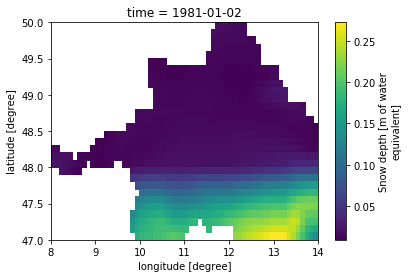

In [6]:
era5_basin['sd'].isel(time=1).plot()

Add the change in snow depth as additional variable.

In [7]:
sd_diff = era5_basin['sd'].diff(dim='time')
sd_diff.name = 'sd_diff'
era5_basin = era5_basin.assign({'sd_diff': sd_diff})

Same for the 2013 case study sample data.

In [8]:
sd_diff_2013 = era5_2013_basin['sd'].diff(dim='time')
sd_diff_2013.name = 'sd_diff'
era5_2013_basin = era5_2013_basin.assign({'sd_diff': sd_diff_2013})

In [9]:
era5_2013_basin

<xarray.Dataset>
Dimensions:      (latitude: 30, longitude: 80, time: 365)
Coordinates:
  * time         (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-12-31
  * latitude     (latitude) float64 49.95 49.85 49.75 ... 47.25 47.15 47.05
  * longitude    (longitude) float64 8.05 8.15 8.25 8.35 ... 15.75 15.85 15.95
Data variables:
    cp           (time, latitude, longitude) float64 nan nan nan ... 0.0 0.0 0.0
    lsp          (time, latitude, longitude) float64 nan nan ... 0.001532
    swvl1        (time, latitude, longitude) float64 nan nan ... 0.388 0.3873
    tcwv         (time, latitude, longitude) float64 nan nan nan ... 12.93 13.16
    ro           (time, latitude, longitude) float64 nan nan ... 1.361e-05
    sd           (time, latitude, longitude) float64 nan nan ... 3.347e-05
    rtp_500-850  (time, latitude, longitude) float64 nan nan ... 3.993e+04
    sd_diff      (time, latitude, longitude) float64 nan nan ... 3.347e-05

Add long-time large-scale precipitation as feature (memory effect).

In [ ]:
era5_basin['lsp-5-11'] = shift_and_aggregate(era5_basin['lsp'], shift=5, aggregate=7)
era5_basin['lsp-12-25'] = shift_and_aggregate(era5_basin['lsp'], shift=12, aggregate=14)
era5_basin['lsp-26-55'] = shift_and_aggregate(era5_basin['lsp'], shift=26, aggregate=30)
era5_basin['lsp-56-180'] = shift_and_aggregate(era5_basin['lsp'], shift=56, aggregate=125)


era5_2013_basin['lsp-5-11'] = shift_and_aggregate(era5_2013_basin['lsp'], shift=5, aggregate=7)
era5_2013_basin['lsp-12-25'] = shift_and_aggregate(era5_2013_basin['lsp'], shift=12, aggregate=14)
era5_2013_basin['lsp-26-55'] = shift_and_aggregate(era5_2013_basin['lsp'], shift=26, aggregate=30)
era5_2013_basin['lsp-56-180'] = shift_and_aggregate(era5_2013_basin['lsp'], shift=56, aggregate=125)

In [ ]:
era5_basin

### Prepare the feature array X and predictand y
For easier use, let's define the preparation routine here.

In [30]:
def prepare_features(x, y, point=None):
    x = x.drop('tcwv')
    x = x.drop('rtp_500-850')
    #features = ['cp', 'lsp', 'ro', 'swvl1', 'sd', 'sd_diff']
    #x = x[features]
        
    for var in ['lsp', 'cp']:
        for i in range(1,4):
            newvar = var+'-'+str(i)
            x[newvar] = x[var].shift(time=i)  # previous precip as current day variable

    # select the point of interest
    if not point:
        poi = dict(latitude=48.35, longitude=13.95)  # point in upper austria
    elif point == 'krems':
        poi = dict(latitude=48.403, longitude=15.615)  # krems (lower austria), outside the test dataset
    
    # average features in the basin
    x_mean = x.mean(['latitude', 'longitude'])

    # select area of interest and average over space for all features
    y_poi = y.interp(poi)
    y_poi_diff = y_poi.diff('time', 1)  # compare predictors to change in discharge
    y_poi_diff.name = 'dis_diff'

    # merge into one dataset
    sample_data = xr.merge([x_mean, y_poi, y_poi_diff])
    sample_data = sample_data.drop(['latitude', 'longitude'])
    return sample_data
sample_data_1 = prepare_features(era5_basin, dis)
sample_data_2013 = prepare_features(era5_2013_basin, dis_2013, point='krems')

In [31]:
sample_data_1.to_netcdf('../../data/features_xy_v2.nc')
sample_data_2013.to_netcdf('../../data/features_xy_2013_v2.nc')